## Introduction

In this notebook, we will explore the performance of CNN algorithm with three robust classifiers, noise adaptation, loss correction, and rank pruning against three dataset with noisy labels.

Two of our datasets have known flip rates for its noisy labels, given in two separate transition matrices. The datasets with known flip rates are FashionMNIST0.5 and FashionMNIST0.6. For the last dataset, CIFAR dataset, we will be demonstrating the method to acquire this transition matrix to estimate the labels' flip rates.

To measure our chosen robust classifiers, we will be using four evaluation metrics: Top-1 Accuracy, Precision, Recall, and F1-Score.

First, let us define our imports and dependencies.

In [ ]:
%pip install scikeras

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.utils import to_categorical

import random

random.seed(42)
np.random.seed(42)

## Utilization Functions

In order to better make the exploration and experiments easier, we will make few utilization functions.

`load_data` function is used to load our data. It takes two parameter, path and filename.

In [2]:
def load_data(path, filename):
    '''
    method to load data.

    parameters
    ----------
    path: str
      path to the dataset.
    filename: str
      name of the dataset.

    Returns
    -------
    X_train, y_train, X_test, y_test.

    '''
    dataset = np.load (path + filename)
    X_train_full = dataset['Xtr']
    y_train_full = dataset['Str']
    X_test = dataset['Xts']
    y_test = dataset['Yts']
    return X_train_full, y_train_full, X_test, y_test

we make a class called `data` to better manage our dataset. This data will be the storage of our training, testing, and validation samples, as well as the transition matrix.

In [3]:
class data():
  """
  class intended to store the data of each dataset.

  """
  def __init__(self, path, filename):
    self.X_train_full, self.y_train_full, self.X_test, self.y_test = load_data(path, filename)
    self.label_list = np.unique(self.y_test)
    self.X_valid = None
    self.y_valid = None
    self.model = None
    self.name = filename[:-4]
    if self.name == "FashionMNIST0.5":
      self.transition_matrix = np.array([[0.5,0.2,0.3],[0.3,0.5,0.2],[0.2,0.3,0.5]])
    elif self.name == "FashionMNIST0.6":
      self.transition_matrix = np.array([[0.4,0.3,0.3],[0.3,0.4,0.3],[0.3,0.3,0.4]])
    else:
      self.transition_matrix = None

  def __str__(self):
    if self.X_valid is None:
      return f"========================\nData of {self.name}\n------------------------\ntraining sample: {self.X_train_full.shape}\ntraining label: {self.y_train_full.shape}\ntesting sample:{self.X_test.shape}\ntesting label: {self.y_test.shape}\nUnique labels: {self.label_list}\nTransition matrix:\n{self.transition_matrix}\n========================"
    else:
      return f"========================\nData of {self.name}\n------------------------\ntraining sample: {self.X_train.shape}\ntraining label: {self.y_train.shape}\nvalidation sample: {self.X_valid.shape}\nvalidation label: {self.y_valid.shape}\ntesting sample:{self.X_test.shape}\ntesting label: {self.y_test.shape}\nUnique labels: {self.label_list}\nTransition matrix:\n{self.transition_matrix}\n========================"

  def split_train_data(self):
    '''
    method to split our training data into training and validation sets.

    '''
    self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(self.X_train_full, self.y_train_full, stratify = self.y_train_full, train_size=0.8, random_state = 0)


We make `plot_images` function to plot our dataset from numpy array into 2D images.

In [4]:
def plot_images(X, row = 1, col = 5, row_figsize = 8, col_figsize = 5, title = "Figure"):
    '''
    method to plot images.

    parameters
    ----------
    X: array
      the data we wish to plot. expects 4d array.
    row: int
      number of rows we wish to display.
    col: int
      number of columns we wish to display.
    row_figsize: int
      the size of each row in the figure.
    col_figsize: int
      the size of each column in the figure.
    title: str
      the title for each image in the figure.

    '''
    plt.figure(figsize = (row_figsize,col_figsize))
    for i in range(row):
      for j in range(col):
        # Get next index of image
        index = col * i + j
        # Plot the image at appropriate place in grid
        plt.subplot(row, col, index + 1)
        if(len(X.shape) == 3):
          plt.imshow(X[index], cmap="binary")
        else:
          plt.imshow(X[index])
        plt.xticks([])
        plt.yticks([])
        plt.title(title + " " + str(index + 1))
        plt.grid(False)

    plt.show()

To show the result of our experiments in graph, we will make a function called `make_graph`.

In [5]:
def make_graph(results):
  """
  method to plot the results into line chart and calculate the average and standard defiation over iterations.

  parameters
  ----------
  results: dictionary
    results of the experiments.

  """
  fig, axes = plt.subplots(len(results), len(results[list(results.keys())[0]]), figsize=(15, 8), sharex=True, sharey=True)

  metrics = ["top1", "precision", "recall", "f1"]

  for i, (classifier, data) in enumerate(results.items()):
    if len(results)>1:
      axes[i, 0].plot(data["top1"], label="Top-1")
      axes[i, 0].set_title(f"{classifier}")
      axes[i, 0].set_xlabel("Iteration")
      axes[i, 0].set_ylabel("Top-1 Score")
      axes[i, 0].legend()
    else:
      axes[0].plot(data["top1"], label="Top-1")
      axes[0].set_title(f"{classifier}")
      axes[0].set_xlabel("Iteration")
      axes[0].set_ylabel("Top-1 Score")
      axes[0].legend()

    for j, metric in enumerate(metrics[1:]):  # Skip accuracy in metrics
      values = data[metric].values()

      for key, line_values in enumerate(values):
        if len(results)>1:
          ax = axes[i, j + 1]
          ax.plot(line_values, label=f"Label {key}")
          ax.set_title(f"{classifier}")
          ax.set_xlabel("Iteration")
          ax.set_ylabel(f"{metric.capitalize()} Score")
          ax.legend()
        else:
          ax = axes[j + 1]
          ax.plot(line_values, label=f"Label {key}")
          ax.set_title(f"{classifier}")
          ax.set_xlabel("Iteration")
          ax.set_ylabel(f"{metric.capitalize()} Score")
          ax.legend()

  plt.tight_layout()
  plt.show()

  for classifier, data in results.items():
    print(f"{classifier} metrics:")
    for metric in metrics:
      if metric == "top1":
        values = np.array(data[metric])
        values_mean = np.nanmean(values)
        values_std = np.nanstd(values)
      else:
        # Calculate mean and std for each label separately
        label_means = []
        label_stds = []

        for label, label_values in data[metric].items():
          label_values = np.array(label_values)
          label_means.append(np.nanmean(label_values))
          label_stds.append(np.nanstd(label_values))

        values_mean = np.array(label_means)
        values_std = np.array(label_stds)

      print(f"{classifier} - {metric.capitalize()} mean = {values_mean}")
      print(f"{classifier} - {metric.capitalize()} st.deviation = {values_std}")
    print()

For our CNN model, we will utilize the Keras library's early stopping to prevent the model to overfit.

In [6]:
#to make sure the session is clear
keras.backend.clear_session()
tf.random.set_seed(42)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 1. Dataset

We will be using three datasets, FashionMNIST0.5, FashionMNIST0.6, and CIFAR dataset.
* FashionMNIST0.5 dataset contains 18000 training and validation samples, with 3000 testing samples. The shape of each image is 28 x 28. The transition matrix is:
$$
\begin{align*}
    T =
    \begin{bmatrix}
    0.5 &  0.2 & 0.3 \\
    0.3 & 0.5 & 0.2 \\
    0.2 & 0.3 & 0.5
    \end{bmatrix}
\end{align*}
$$
* FashionMNIST0.6 dataset contains 18000 training and validation samples, with 3000 testing samples. The shape of each image is 28 x 28. The transition matrix is:
$$
\begin{align*}
    T =
    \begin{bmatrix}
    0.4 &  0.3 & 0.3 \\
    0.3 & 0.4 & 0.3 \\
    0.3 & 0.3 & 0.4
    \end{bmatrix}
\end{align*}
$$
* CIFAR dataset contains 15000 training and validation samples, with 3000 testing samples. The shape of each image is 32 x 32 x 3. The transition matrix is unknown.

## 1.1. Data Exploration

In [6]:
path = "data/"

Data of FashionMNIST0.5
------------------------
training sample: (18000, 28, 28)
training label: (18000,)
testing sample:(3000, 28, 28)
testing label: (3000,)
Unique labels: [0 1 2]
Transition matrix:
[[0.5 0.2 0.3]
 [0.3 0.5 0.2]
 [0.2 0.3 0.5]]
After splitting:
Data of FashionMNIST0.5
------------------------
training sample: (14400, 28, 28)
training label: (14400,)
validation sample: (3600, 28, 28)
validation label: (3600,)
testing sample:(3000, 28, 28)
testing label: (3000,)
Unique labels: [0 1 2]
Transition matrix:
[[0.5 0.2 0.3]
 [0.3 0.5 0.2]
 [0.2 0.3 0.5]]



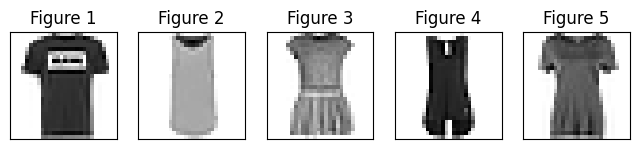

In [7]:
filename = "FashionMNIST0.5.npz"
fashion05 = data(path,filename)
print(fashion05)
print("After splitting:")
fashion05.split_train_data()
print(fashion05)
print()
plot_images(fashion05.X_train_full, row=1, col=5)

Data of FashionMNIST0.6
------------------------
training sample: (18000, 28, 28)
training label: (18000,)
testing sample:(3000, 28, 28)
testing label: (3000,)
Unique labels: [0 1 2]
Transition matrix:
[[0.4 0.3 0.3]
 [0.3 0.4 0.3]
 [0.3 0.3 0.4]]
After splitting:
Data of FashionMNIST0.6
------------------------
training sample: (14400, 28, 28)
training label: (14400,)
validation sample: (3600, 28, 28)
validation label: (3600,)
testing sample:(3000, 28, 28)
testing label: (3000,)
Unique labels: [0 1 2]
Transition matrix:
[[0.4 0.3 0.3]
 [0.3 0.4 0.3]
 [0.3 0.3 0.4]]



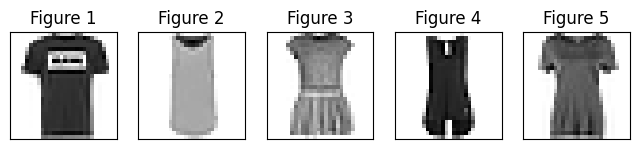

In [98]:
filename = "FashionMNIST0.6.npz"
fashion06 = data(path,filename)
print(fashion06)
print("After splitting:")
fashion06.split_train_data()
print(fashion06)
print()
plot_images(fashion06.X_train_full, row=1, col=5)

Data of CIFAR
------------------------
training sample: (15000, 32, 32, 3)
training label: (15000,)
testing sample:(3000, 32, 32, 3)
testing label: (3000,)
Unique labels: [0 1 2]
Transition matrix:
None
After splitting:
Data of CIFAR
------------------------
training sample: (12000, 32, 32, 3)
training label: (12000,)
validation sample: (3000, 32, 32, 3)
validation label: (3000,)
testing sample:(3000, 32, 32, 3)
testing label: (3000,)
Unique labels: [0 1 2]
Transition matrix:
None



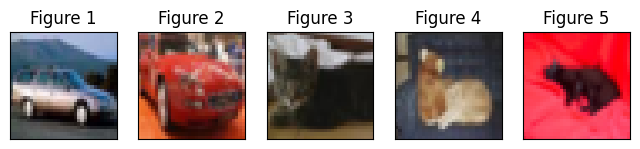

In [99]:
filename = "CIFAR.npz"
cifar = data(path,filename)
print(cifar)
print("After splitting:")
cifar.split_train_data()
print(cifar)
print()
plot_images(cifar.X_train_full, row=1, col=5)

## 1.2. Preprocessing

To help the model to converge faster and improves generalization, we will do normalization to our data. This is done by dividing each pixel values by the maximum value that can happen. By doing this, each pixel value that originally ranges from 0-255 becomes 0-1.

In [7]:
def preprocess(data):
  """
  method to preprocess the data.

  parameters
  ----------
  data: object
    our dataset in the class we defined previously.

  """
  if data.X_train_full.dtype == "uint8":
    if data.X_valid is None:
      data.X_train_full = data.X_train_full / 255
      data.X_test = data.X_test / 255
    else:
      data.X_train_full = data.X_train_full / 255
      data.X_train = data.X_train / 255
      data.X_valid = data.X_valid / 255
      data.X_test = data.X_test / 255
  else:
    print("already preprocessed.")

The function above will change the data type of our X from uint8 to float64.

In [100]:
print(fashion05.X_test.dtype)
preprocess(fashion05)
preprocess(fashion06)
preprocess(cifar)
print(fashion05.X_test.dtype)

uint8
float64


# 2. Evaluation Metrics

In this experiment, we will be using four evaluation metrics: top-1 accuracy, precision, recall, and F1-score using the help of sklearn library.#2. Machine Learning Algorithms

$$
\begin{align*}
Top\:1\:Accuracy = \frac{TP+TN}{test\:samples\:size}
\end{align*}
$$

Measures the score of the model correctly assigning the highest probability value to a correct label given a training input

$$
\begin{align*}
Precision = \frac{TP}{TP + FP}
\end{align*}
$$
The ability of a classification model to return only the data points in a class.

$$
\begin{align*}
Recall = \frac{TP}{TP + FN}
\end{align*}
$$
The ability of a classification model to identify all data points in a relevant class.

$$
\begin{align*}
F1\:Score = 2* \frac{Precision * Recall}{Precision + Recall}
\end{align*}
$$
A single metric that combines recall and precision using the harmonic mean.

In [8]:
def evaluation_metrics(true_labels, predicted_labels, average=None):
  '''
  method to evaluate the performance of the classifier using top-1 accuracy, precision, recall, and f1-score methods.

  parameters
  ----------
  true_labels: array
    the true label of our data
  predicted_labels: array
    the label predicted by our machine

  returns
  -------
  float
    score performance

  '''
  top1 = accuracy_score(true_labels, predicted_labels)
  precision = precision_score(true_labels, predicted_labels, average=average)
  recall = recall_score(true_labels, predicted_labels, average=average)
  f1 = f1_score(true_labels, predicted_labels, average=average)

  return top1, precision, recall, f1

# 3. Base Classifiers

We use the same base classifiers (CNN) for all optimization with different parameters in each dataset. In this section, we will do parameter tuning, building our CNN model with the best parameters, then using the base classifier we will estimate the transition matrix for our dataset.

In [9]:
def cnn_alg(input_shape, class_number, activation_function, num_filters, num_layers):
  '''
  method to build a CNN algorithm.

  parameters
  ----------
  input_shape: array
    an array of the image size.
  class_number: int
    number of class classification.
  activation_function: str
    layers activation parameter.
  num_filters: int
    number of filters for each layer.
  num_layers: int
    number of layers.

  Returns
  -------
  CNN algorithm model

  '''
  model = keras.models.Sequential()

  model.add(keras.Input(shape = tuple(input_shape)))

  #Add layers according to the number of layers
  for layer in range(num_layers):
    model.add(keras.layers.Conv2D(num_filters, kernel_size=(3, 3), activation=activation_function))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(0.5))

  #the output layer is based on the unique value of Y (labels)
  model.add(keras.layers.Dense(class_number, activation = 'softmax'))

  return model

## 3.1. Parameters Tuning

There's no one answer to fit all questions. In order to better accomodate each dataset, we will tune our parameters in the base CNN model for each scenario.

In [ ]:
param_grid = {
  "num_filters": [32, 64, 128],
  "num_layers": [1, 2, 3],
  "batch_size": [32, 64, 128],
  "activation_function": ["relu", "sigmoid", "tanh"]
}

### 3.1.1. FashionMNIST0.5

In [ ]:
cnn_classifier = KerasClassifier(cnn_alg,
                                 input_shape=[28,28,1],
                                 class_number=len(fashion05.label_list),
                                 activation_function="relu",
                                 loss="sparse_categorical_crossentropy",
                                 optimizer="adam",
                                 optimizer__learning_rate=0.01,
                                 num_filters=64,
                                 num_layers=2,
                                 batch_size=32,
                                 metrics=["accuracy"]
                                 )

In [ ]:
grid_search_cv = GridSearchCV(cnn_classifier, param_grid, cv=3, verbose=2)
grid_search_result = grid_search_cv.fit(fashion05.X_train, fashion05.y_train, epochs=5)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Epoch 1/5
300/300 [==============================] - 5s 15ms/step - loss: 4.2845 - accuracy: 0.3606
Epoch 2/5
300/300 [==============================] - 5s 18ms/step - loss: 1.0873 - accuracy: 0.3936
Epoch 3/5
300/300 [==============================] - 4s 14ms/step - loss: 1.0872 - accuracy: 0.3978
Epoch 4/5
300/300 [==============================] - 6s 20ms/step - loss: 1.0847 - accuracy: 0.4023
Epoch 5/5
150/150 [==============================] - 1s 5ms/step
[CV] END activation_function=relu, batch_size=32, num_filters=32, num_layers=1; total time=  27.1s
Epoch 1/5
300/300 [==============================] - 5s 14ms/step - loss: 5.1657 - accuracy: 0.3792
Epoch 2/5
300/300 [==============================] - 6s 19ms/step - loss: 1.0890 - accuracy: 0.3915
Epoch 3/5
300/300 [==============================] - 5s 15ms/step - loss: 1.0942 - accuracy: 0.3787
Epoch 4/5
300/300 [==============================] - 4s 14ms/step - loss: 

In [ ]:
best_parameters = grid_search_result.best_params_
print(best_parameters)

{'activation_function': 'relu', 'batch_size': 64, 'num_filters': 64, 'num_layers': 2}


### 3.1.2. FashionMNIST0.6

In [ ]:
cnn_classifier = KerasClassifier(cnn_alg,
                                 input_shape=[28,28,1],
                                 class_number=len(fashion06.label_list),
                                 activation_function="relu",
                                 loss="sparse_categorical_crossentropy",
                                 optimizer="adam",
                                 optimizer__learning_rate=0.01,
                                 num_filters=64,
                                 num_layers=2,
                                 batch_size=32,
                                 metrics=["accuracy"]
                                 )

In [ ]:
grid_search_cv = GridSearchCV(cnn_classifier, param_grid, cv=3, verbose=2)
grid_search_result = grid_search_cv.fit(fashion06.X_train, fashion06.y_train, epochs=5)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Epoch 1/5
300/300 [==============================] - 3s 9ms/step - loss: 1.1024 - accuracy: 0.3388
Epoch 2/5
300/300 [==============================] - 2s 8ms/step - loss: 1.0995 - accuracy: 0.3246
Epoch 3/5
300/300 [==============================] - 2s 7ms/step - loss: 1.0997 - accuracy: 0.3298
Epoch 4/5
300/300 [==============================] - 2s 8ms/step - loss: 1.0991 - accuracy: 0.3367
Epoch 5/5
150/150 [==============================] - 1s 5ms/step
[CV] END activation_function=relu, batch_size=32, num_filters=32, num_layers=1; total time=  15.5s
Epoch 1/5
300/300 [==============================] - 3s 9ms/step - loss: 1.1027 - accuracy: 0.3375
Epoch 2/5
300/300 [==============================] - 2s 8ms/step - loss: 1.0983 - accuracy: 0.3492
Epoch 3/5
300/300 [==============================] - 2s 8ms/step - loss: 1.0971 - accuracy: 0.3535
Epoch 4/5
300/300 [==============================] - 2s 8ms/step - loss: 1.0961 -

In [ ]:
best_parameters = grid_search_result.best_params_
print(best_parameters)

{'activation_function': 'tanh', 'batch_size': 128, 'num_filters': 32, 'num_layers': 3}


### 3.1.3. CIFAR

In [ ]:
cnn_classifier = KerasClassifier(cnn_alg,
                                 input_shape=cifar.X_train.shape[1:],
                                 class_number=len(cifar.label_list),
                                 activation_function="relu",
                                 loss="sparse_categorical_crossentropy",
                                 optimizer="adam",
                                 optimizer__learning_rate=0.01,
                                 num_filters=64,
                                 num_layers=2,
                                 batch_size=32,
                                 metrics=["accuracy"]
                                 )

In [ ]:
grid_search_cv = GridSearchCV(cnn_classifier, param_grid, cv=3, verbose=2)
grid_search_result = grid_search_cv.fit(cifar.X_train, cifar.y_train, epochs=5)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Epoch 1/5
250/250 [==============================] - 6s 19ms/step - loss: 1.1075 - accuracy: 0.3374
Epoch 2/5
250/250 [==============================] - 6s 26ms/step - loss: 1.0995 - accuracy: 0.3274
Epoch 3/5
250/250 [==============================] - 5s 20ms/step - loss: 1.0998 - accuracy: 0.3256
Epoch 4/5
250/250 [==============================] - 5s 19ms/step - loss: 1.0990 - accuracy: 0.3311
Epoch 5/5
125/125 [==============================] - 1s 7ms/step
[CV] END activation_function=relu, batch_size=32, num_filters=32, num_layers=1; total time=  44.0s
Epoch 1/5
250/250 [==============================] - 5s 19ms/step - loss: 1.1400 - accuracy: 0.3311
Epoch 2/5
250/250 [==============================] - 9s 35ms/step - loss: 1.0991 - accuracy: 0.3310
Epoch 3/5
250/250 [==============================] - 5s 19ms/step - loss: 1.0994 - accuracy: 0.3306
Epoch 4/5
250/250 [==============================] - 5s 21ms/step - loss: 

In [ ]:
best_parameters = grid_search_result.best_params_
print(best_parameters)

{'activation_function': 'tanh', 'batch_size': 128, 'num_filters': 64, 'num_layers': 2}


## 3.2. Base CNN Model

Based on the results of parameters tuning, we build our CNN model.

### 3.2.1. FashionMNIST0.5

In [101]:
fashion05.model = cnn_alg(input_shape = [28,28,1],
                          class_number = len(fashion05.label_list),
                          activation_function = "relu",
                          num_filters = 64,
                          num_layers = 2)
fashion05.model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

fashion05.model.fit(fashion05.X_train,
                    fashion05.y_train,
                    batch_size = 64,
                    validation_data = (fashion05.X_valid, fashion05.y_valid),
                    epochs = 500,
                    callbacks = [early_stopping])

Epoch 1/500
225/225 [==============================] - 12s 51ms/step - loss: 1.0667 - accuracy: 0.4441 - val_loss: 1.0516 - val_accuracy: 0.4761
Epoch 2/500
225/225 [==============================] - 13s 56ms/step - loss: 1.0512 - accuracy: 0.4723 - val_loss: 1.0467 - val_accuracy: 0.4783
Epoch 3/500
225/225 [==============================] - 11s 49ms/step - loss: 1.0485 - accuracy: 0.4762 - val_loss: 1.0469 - val_accuracy: 0.4769
Epoch 4/500
225/225 [==============================] - 11s 48ms/step - loss: 1.0462 - accuracy: 0.4793 - val_loss: 1.0460 - val_accuracy: 0.4836
Epoch 5/500
225/225 [==============================] - 11s 48ms/step - loss: 1.0443 - accuracy: 0.4799 - val_loss: 1.0447 - val_accuracy: 0.4828
Epoch 6/500
225/225 [==============================] - 11s 48ms/step - loss: 1.0443 - accuracy: 0.4808 - val_loss: 1.0463 - val_accuracy: 0.4817
Epoch 7/500
225/225 [==============================] - 11s 48ms/step - loss: 1.0424 - accuracy: 0.4830 - val_loss: 1.0480 - val_ac

### 3.2.2. FashionMNIST0.6

In [104]:
fashion06.model = cnn_alg(input_shape = [28,28,1],
                          class_number = len(fashion06.label_list),
                          activation_function = "tanh",
                          num_filters = 32,
                          num_layers = 3)
fashion06.model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

fashion06.model.fit(fashion06.X_train,
                    fashion06.y_train,
                    batch_size = 128,
                    validation_data = (fashion06.X_valid, fashion06.y_valid),
                    epochs = 500,
                    callbacks = [early_stopping])

Epoch 1/500
113/113 [==============================] - 7s 54ms/step - loss: 1.1002 - accuracy: 0.3591 - val_loss: 1.0935 - val_accuracy: 0.3828
Epoch 2/500
113/113 [==============================] - 6s 51ms/step - loss: 1.0939 - accuracy: 0.3805 - val_loss: 1.0937 - val_accuracy: 0.3822
Epoch 3/500
113/113 [==============================] - 6s 53ms/step - loss: 1.0923 - accuracy: 0.3849 - val_loss: 1.0915 - val_accuracy: 0.3894
Epoch 4/500
113/113 [==============================] - 6s 50ms/step - loss: 1.0909 - accuracy: 0.3887 - val_loss: 1.0921 - val_accuracy: 0.3956
Epoch 5/500
113/113 [==============================] - 6s 49ms/step - loss: 1.0896 - accuracy: 0.3896 - val_loss: 1.0953 - val_accuracy: 0.3744
Epoch 6/500
113/113 [==============================] - 6s 49ms/step - loss: 1.0897 - accuracy: 0.3893 - val_loss: 1.0915 - val_accuracy: 0.3914
Epoch 7/500
113/113 [==============================] - 5s 47ms/step - loss: 1.0886 - accuracy: 0.3972 - val_loss: 1.0913 - val_accuracy:

### 3.2.3. CIFAR

In [105]:
cifar.model = cnn_alg(input_shape = [32,32,3],
                      class_number = len(cifar.label_list),
                      activation_function = "tanh",
                      num_filters = 64,
                      num_layers = 2
                      )
cifar.model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

cifar.model.fit(cifar.X_train,
                cifar.y_train,
                batch_size = 128,
                validation_data = (cifar.X_valid, cifar.y_valid),
                epochs = 500,
                callbacks = [early_stopping])

Epoch 1/500
94/94 [==============================] - 14s 145ms/step - loss: 1.1067 - accuracy: 0.3496 - val_loss: 1.0947 - val_accuracy: 0.3683
Epoch 2/500
94/94 [==============================] - 13s 141ms/step - loss: 1.0954 - accuracy: 0.3646 - val_loss: 1.0962 - val_accuracy: 0.3603
Epoch 3/500
94/94 [==============================] - 13s 136ms/step - loss: 1.0928 - accuracy: 0.3742 - val_loss: 1.0928 - val_accuracy: 0.3680
Epoch 4/500
94/94 [==============================] - 16s 167ms/step - loss: 1.0893 - accuracy: 0.3860 - val_loss: 1.0966 - val_accuracy: 0.3697
Epoch 5/500
94/94 [==============================] - 15s 163ms/step - loss: 1.0867 - accuracy: 0.3895 - val_loss: 1.0971 - val_accuracy: 0.3740
Epoch 6/500
94/94 [==============================] - 14s 152ms/step - loss: 1.0839 - accuracy: 0.3989 - val_loss: 1.0994 - val_accuracy: 0.3607
Epoch 7/500
94/94 [==============================] - 13s 140ms/step - loss: 1.0838 - accuracy: 0.4015 - val_loss: 1.0955 - val_accuracy:

## 3.3. Transition Matrix Estimation

When estimating transition matrix, we will compare two estimation, one with average value and one without it. We will use the pre-established transition matrix from FashionMNIST0.5 and FashionMNIST0.6 to validate the effectiveness of our method, and apply it to our CIFAR dataset.

In [106]:
def estimate_matrix(data, predictions, average=True):
  """
  method to estimate the transition matrix of a dataset using the prediction results of training with noise labels.

  parameters
  ----------
  data: data
    the dataset in which we want to estimate.
  predictions: NumPy array
    the predictions result of the model when tested on testing samples.
  average: boolean
    True to use average probability for estimating transition matrix.

  returns
  -------
  array
    transition matrix estimation.

  """
  #get all the label
  y_pred = np.argmax(predictions, axis=1)

  num_classes = len(data.label_list)

  #empty matrix
  T = np.zeros((num_classes, num_classes))

  #iterate through all possible labels
  for i in range(num_classes):
    if average:
        X_i = predictions[(y_pred == i)]
        T[i, :] = np.mean(X_i, axis=0)
    else:
      idx = np.argmax(predictions[:, i])
      for j in np.arange(num_classes):
        T[i, j] = predictions[idx, j]

  return T

### 3.3.1. FashionMNIST0.5

In [107]:
tmatrix_avg = estimate_matrix(fashion05, fashion05.model.predict(fashion05.X_test))
tmatrix = estimate_matrix(fashion05, fashion05.model.predict(fashion05.X_test), average=False)

94/94 [==============================] - 1s 6ms/step


In [108]:
print("original matrix:")
print(fashion05.transition_matrix)
print("\nestimated matrix with average:")
print(tmatrix_avg)
error = np.sum(np.abs(tmatrix_avg-fashion05.transition_matrix)) / np.sum(np.abs(fashion05.transition_matrix))
print(f"error value: {error}")
print("\nestimated matrix without average:")
print(tmatrix)
error = np.sum(np.abs(tmatrix-fashion05.transition_matrix)) / np.sum(np.abs(fashion05.transition_matrix))
print(f"error value: {error}")

original matrix:
[[0.5 0.2 0.3]
 [0.3 0.5 0.2]
 [0.2 0.3 0.5]]

estimated matrix with average:
[[0.45308113 0.30230224 0.24461702]
 [0.22175944 0.47761366 0.30062667]
 [0.30606276 0.23920831 0.45472851]]
error value: 0.20599453250567115

estimated matrix without average:
[[0.64263952 0.24000825 0.11735228]
 [0.16744566 0.58316445 0.24938989]
 [0.23473285 0.12546824 0.63979888]]
error value: 0.3264892185727755


### 3.3.2. FashionMNIST0.6

In [109]:
tmatrix_avg = estimate_matrix(fashion06, fashion06.model.predict(fashion06.X_test))
tmatrix = estimate_matrix(fashion06, fashion06.model.predict(fashion06.X_test), average=False)

94/94 [==============================] - 0s 4ms/step


In [110]:
print("original matrix:")
print(fashion06.transition_matrix)
print("\nestimated matrix with average:")
print(tmatrix_avg)
error = np.sum(np.abs(tmatrix_avg-fashion06.transition_matrix)) / np.sum(np.abs(fashion06.transition_matrix))
print(f"error value: {error}")
print("\nestimated matrix without average:")
print(tmatrix)
error = np.sum(np.abs(tmatrix-fashion06.transition_matrix)) / np.sum(np.abs(fashion06.transition_matrix))
print(f"error value: {error}")

original matrix:
[[0.4 0.3 0.3]
 [0.3 0.4 0.3]
 [0.3 0.3 0.4]]

estimated matrix with average:
[[0.38465899 0.30378175 0.31155902]
 [0.29042003 0.3878172  0.32176268]
 [0.30343056 0.31072032 0.38584945]]
error value: 0.034169554710388225

estimated matrix without average:
[[0.49432382 0.25794598 0.24773021]
 [0.22877927 0.48547906 0.28574178]
 [0.23326802 0.23580492 0.53092706]]
error value: 0.20715325276056923


### 3.3.3. CIFAR

In [111]:
tmatrix_avg = estimate_matrix(cifar, cifar.model.predict(cifar.X_test))
tmatrix = estimate_matrix(cifar, cifar.model.predict(cifar.X_test), average=False)

94/94 [==============================] - 1s 8ms/step


In [113]:
print("\nestimated matrix with average:")
print(tmatrix_avg)
print()
print("estimated matrix without average:")
print(tmatrix)

cifar.transition_matrix = tmatrix


estimated matrix with average:
[[0.39567468 0.31572714 0.28859809]
 [0.31916186 0.37180713 0.30903122]
 [0.31560791 0.31439203 0.37000003]]

estimated matrix without average:
[[0.53302318 0.29740822 0.1695686 ]
 [0.2835944  0.47563791 0.24076772]
 [0.31739247 0.21497555 0.467632  ]]


# 4. Robust Classifiers

In this experiment, we are going to use three different method to increase the robustness of our CNN model. The first one is noise adaptation layer, the second one is loss correction approach, and the last one is rank pruning.

Both noise adaptation and loss correction require us to have transition matrix beforehand. Unlike them, rank pruning doesn't require any transition matrix.

## 4.1. Noise Adaptation Layer
This method utilizes an additional output softmax layer on top of a CNN architecture that is used to directly model a given transition matrix against the baseline predicted output.

In [11]:
# do you think we're gonna get penalized for directly copying this class lol

from keras.layers import Dense
from keras import backend as K
class Channel(Dense):
    """
    Implement simple noise adaptation layer.

    References
        Goldberger & Ben-Reuven, Training deep neural-networks using a noise
        adaptation layer, ICLR 2017
        https://openreview.net/forum?id=H12GRgcxg

    # Arguments
        output_dim: int > 0
              default is input_dim which is known at build time
        See Dense layer for more arguments. There is no bias and the arguments
        `bias`, `b_regularizer`, `b_constraint` are not used.
    """

    def __init__(self, units = None, **kwargs):
        kwargs['use_bias'] = False
        if 'activation' not in kwargs:
            kwargs['activation'] = 'softmax'
        super(Channel, self).__init__(units, **kwargs)

    def build(self, input_shape):
        if self.units is None:
            self.units = input_shape[-1]
        super(Channel, self).build(input_shape)

    def call(self, x, mask=None):
        """
        :param x: the output of a baseline classifier model passed as an input
        It has a shape of (batch_size, input_dim) and
        baseline_output.sum(axis=-1) == 1
        :param mask: ignored
        :return: the baseline output corrected by a channel matrix
        """
        # convert W to the channel probability (stochastic) matrix
        # channel_matrix.sum(axis=-1) == 1
        # channel_matrix.shape == (input_dim, input_dim)
        channel_matrix = self.activation(self.kernel)

        # multiply the channel matrix with the baseline output:
        # channel_matrix[0,0] is the probability that baseline output 0 will get
        #  to channeled_output 0
        # channel_matrix[0,1] is the probability that baseline output 0 will get
        #  to channeled_output 1 ...
        # ...
        # channel_matrix[1,0] is the probability that baseline output 1 will get
        #  to channeled_output 0 ...
        #
        # we want output[b,0] = x[b,0] * channel_matrix[0,0] + \
        #                              x[b,1] * channel_matrix[1,0] + ...
        # so we do a dot product of axis -1 in x with axis 0 in channel_matrix
        return K.dot(x, channel_matrix)

In [12]:
def cnn_noise_adapted(input_shape, class_number, activation_function, num_filters, num_layers, t_matrix):
  '''
  method to build a CNN algorithm.

  parameters
  ----------
  input_shape: array
    an array of the image size.
  class_number: int
    number of class classification.
  activation_function: str
    layers activation parameter.
  num_filters: int
    number of filters for each layer.
  num_layers: int
    number of layers.

  returns
  -------
  CNN algorithm model

  '''

  # due to the custom layer we have to implement,
  # for this method we have to build the keras
  # CNN with Functional API.

  # this is the same exact model as the cnn_alg() function,
  # just with the Functional API instead of Sequential.

  train_inputs = keras.Input(shape=tuple(input_shape))

  conv = keras.layers.Conv2D(num_filters, kernel_size=(3, 3), activation=activation_function)(train_inputs)
  pool = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)

  if(num_layers > 0):
    for layer in range(num_layers-1):
      conv = keras.layers.Conv2D(num_filters, kernel_size=(3, 3), activation=activation_function)(pool)
      pool = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)

  flat = keras.layers.Flatten()(pool)
  dropout = keras.layers.Dropout(0.5)(flat)
  baseline_output = keras.layers.Dense(class_number, activation='softmax', name='baseline')(dropout)
  channeled_output = Channel(class_number,name='channel',weights=[t_matrix])(baseline_output)
  model = keras.Model(inputs=train_inputs, outputs=channeled_output)

  return model

## 4.2. Loss Correction

this method make a loss function based on transition matrix.

In [13]:
def calculate_loss(tmatrix):
  """
  method to calculate loss based on transition matrix using forward method.

  parameters
  ----------
  tmatrix: NumPy array
    transition matrix.

  returns
  -------
  function
    loss function.

  """
  tmatrix = K.constant(tmatrix)
  def loss(y_true, y_pred):
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    return -K.sum(y_true * K.log(K.dot(y_pred, tmatrix)), axis=-1)

  return loss

In [14]:
def loss_correction(param_grid, tmatrix):
  """
  method to do loss correction approach for robust classifier.

  parameters
  ----------
  param_grid: dictionary
    a dictionary consisting all parameters for cnn model.
  tmatrix: NumPy array
    transition matrix.

  returns
  -------
  CNN model with updated loss function.

  """
  model = cnn_alg(**param_grid)
  loss_function = calculate_loss(tmatrix)
  model.compile(loss=loss_function, optimizer = "adam", metrics = ['accuracy'])
  return model


## 4.3. Rank Pruning

Rank pruning is one of robust classifier that doesn't require transition matrix. It consists of two parts: estimating noise rates and prune inconsistent samples.

In [73]:
def compute_noise_rates(y, prob_true):
  """
  method to compute the noise rates based on the positive probability

  parameters
  ----------
  y: NumPy array
    binary label for training samples.
  prob_true: NumPy array
    array of predicted probability with label = 1.

  returns
  -------
  rho1: float
    fraction of samples mislabeled as negative.
  rho0: float
    fraction of samples mislabeled as positive.

  """

  pos_lb_thresold = np.mean(prob_true[y==1])
  neg_ub_thresold = np.mean(prob_true[y==0])
  n_most_pos = np.sum((prob_true >= pos_lb_thresold) & (y == 0))
  n_least_pos = np.sum((prob_true <= neg_ub_thresold) & (y == 0))
  p_most_pos = np.sum((prob_true >= pos_lb_thresold) & (y == 1))
  p_least_pos = np.sum((prob_true <= neg_ub_thresold) & (y == 1))

  rho0 = p_least_pos / (n_least_pos + p_least_pos)
  rho1 = n_most_pos / (n_most_pos + p_most_pos)

  return rho1, rho0


In [74]:
def cross_val_fit(X, y, n_folds = 3):
  """
  method to do cross validation using logreg classifier. Computes out-of-sample predicted probability P(s=k|x) for each example
  x in X using cross validation while computing confident count noise rates within each cross-validated, returning the average noise rates.

  parameters
  ----------
  datasest: data
    data storing all the samples.
  pos_lb_thresold: float
    P(s^=1|s=1). If an input has probability greater than this float, it counts as having hidden label y = 1.
  neg_ub_thresold: float
    P(s^=1|s=0). If an input has probability lower than this float, it counts as having hidden label y = 0.
  n_folds: int
    Number of folds to compute.

  returns
  -------
  rho1: float
    average fraction of samples mislabeled as negative over cross validation
  rho0: float
    average fraction of samples mislabeled as positive over cross validation
  prob_true: NumPy array
    out of sample predicted probability

  """
  num_class = len(np.unique(y))
  clf = LogisticRegression(max_iter=2000)
  X = X.reshape((X.shape[0], -1))

  kfold = StratifiedKFold(n_splits = n_folds, shuffle = True)
  rho1_list = []
  rho0_list = []
  prob_true = np.zeros((len(X),num_class))

  for k, (cv_train, cv_val) in enumerate(kfold.split(X, y)):
    X_train_cv, X_valid_cv = X[cv_train], X[cv_val]
    y_train_cv, y_valid_cv = y[cv_train], y[cv_val]

    clf.fit(X_train_cv, y_train_cv)
    prob_true_cv = clf.predict_proba(X_valid_cv)
    prob_true[cv_val] = prob_true_cv

    rh1_cv, rh0_cv = compute_noise_rates(
      y = y_valid_cv,
      prob_true = prob_true_cv[:,1]
    )

  rho1_list.append(rh1_cv)
  rho0_list.append(rh0_cv)

  return np.mean(rho1_list), np.mean(rho0_list), prob_true

In [75]:
def get_noisy_indices(phi1, phi0, prob_true, y):
  '''
  method to get the index of noisy data which will be removed from training set.

  parameters
  ----------
  phi1: float
    inverse noise rates.
  phi0: float
    inverse noise rates.
  prob_true: NumPy array
    predicted probability.
  y: NumPy array
    binary label for training samples.

  returns
  -------
  list
    list of indices of unconfident data.

  '''

  pos_noisy = sum(y==1)
  neg_noisy = sum(y==0)
  k1 = int(pos_noisy * phi1)
  k0 = int(neg_noisy * phi0)

  k_smallest = np.partition(prob_true[y==1], k1)[k1]
  k_largest = np.partition(prob_true[y==0], k0)[k0]

  conf_indices = ((prob_true > k_largest) & (y == 0)) | ((prob_true < k_smallest) & (y == 1))
  return conf_indices

In [76]:
def rank_pruning(dataset):
  """
  method for rank pruning. Consists of two parts: Estimates noise rates and prune inconsistent samples.

  parameters
  ----------
  dataset: data
    the dataset with class data, storing the model and samples.

  return
  ------
  list
    evaluation score for each label.

  """
  top1_list = []
  precision_list = []
  recall_list = []
  f1_list = []

  #iterate through all the possible label
  for i in dataset.label_list:
    X_train_p = dataset.X_train
    y_train_p = dataset.y_train
    X_test_p = dataset.X_test
    y_test_p = dataset.y_test
    X_val_p = dataset.X_valid
    y_val_p = dataset.y_valid

    #relabel the y, make the current label = 1 and other labels = 0
    y_train_p = np.array(y_train_p == i, dtype=int)
    y_test_p = np.array(y_test_p == i, dtype=int)
    y_val_p = np.array(y_val_p == i, dtype=int)

    rho1, rho0, prob_true = cross_val_fit(X_train_p, y_train_p)
    prob_true = prob_true[:,1]

    if rho1+rho0 >= 1:
      print("rho + rho0 exceed 1: doesn't pass the requirements for rank pruning.")
      top1_list.append(np.nan)
      precision_list.append(np.nan)
      recall_list.append(np.nan)
      f1_list.append(np.nan)
      continue

    ps1 = sum(y_train_p)/len(y_train_p)
    py1 = (ps1-rho0)/(1-rho1-rho0)

    #calculating inversed noise rates
    phi1 = (rho0*(1-py1))/ps1
    phi0 = (rho1*py1)/(1-ps1)
    phi1 = min(max(phi1, 0.0), 0.9999)
    phi0 = min(max(phi0, 0.0), 0.9999)

    prune_mask = get_noisy_indices(phi1 = phi1, phi0 = phi0, prob_true = prob_true, y = y_train_p)

    #False for noisy labels = removed
    X_mask = ~prune_mask
    X_conf = X_train_p[X_mask]
    y_conf = y_train_p[X_mask]

    print(f"\nrank pruning for label: {i}")
    print(f"rho1: {rho1}, rho0: {rho0}")
    print(f"phi1: {phi1}, phi0: {phi0}")
    print(f"Number of confident samples: {X_conf.shape[0]}")

    sample_weight = np.ones(X_conf.shape[0])
    sample_weight[y_conf == 1] = 1 / (1 - rho1)
    sample_weight[y_conf == 0] = 1 / (1 - rho0)

    # fit the model with sample weight
    keras.backend.clear_session()
    if dataset.name == "FashionMNIST0.5":
      input_shape = [28,28,1]
      class_number = len(fashion05.label_list)
      activation_function = "relu"
      num_filters = 64
      num_layers = 2
      batch_size = 64
    elif dataset.name == "FashionMNIST0.6":
      input_shape = [28,28,1]
      class_number = len(fashion06.label_list)
      activation_function = "tanh"
      num_filters = 32
      num_layers = 3
      batch_size = 128
    elif dataset.name == "CIFAR":
      input_shape = [32,32,3]
      class_number = len(cifar.label_list)
      activation_function = "tanh"
      num_filters = 64
      num_layers = 2
      batch_size = 128
    else:
      raise Exception("invalid dataset.")

    clf = cnn_alg(input_shape = input_shape,
                  class_number = class_number,
                  activation_function = activation_function,
                  num_filters = num_filters,
                  num_layers = num_layers)
    clf.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])
    clf.fit(X_conf,
            y_conf,
            sample_weight = sample_weight,
            batch_size = batch_size,
            validation_data = (X_val_p, y_val_p),
            epochs = 500,
            callbacks = [early_stopping],
            verbose = 0)

    pred = (clf.predict(X_test_p)[:,1] >= 0.5).astype(int)
    top1, precision, recall, f1 = evaluation_metrics(y_test_p, pred, average="weighted")
    print("Model performance:")
    print(f"top1 score: {top1}\nprecision: {precision}\nrecall: {recall}\nf1: {f1}")
    top1_list.append(top1)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

  return top1_list, precision_list, recall_list, f1_list


# 5. Experiments

In [17]:
def run_experiments(classifiers, dataset, param_grid, batch_size, num_iters = 10):
  results = {classifier: {"top1": [],
                          "precision": {0:[], 1:[], 2:[]},
                          "recall": {0:[], 1:[], 2:[]},
                          "f1": {0:[], 1:[], 2:[]}
                          } for classifier in classifiers}

  tmatrix = dataset.transition_matrix

  print("\nRunning Experiments ======================================>")
  for i in range(num_iters):
    print(f"\nIteration Number {i+1}")
    for clf in classifiers:
      keras.backend.clear_session()
      print(f"Current model: {clf}")
      if clf == "base CNN":
        model = cnn_alg(**param_grid)
        model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])
        model.fit(dataset.X_train,
                  dataset.y_train,
                  batch_size = batch_size,
                  validation_data = (dataset.X_valid, dataset.y_valid),
                  epochs = 500,
                  callbacks = [early_stopping])
        predictions = model.predict(dataset.X_test)
        y_pred = np.argmax(predictions, axis=1)
        top1, precision, recall, f1 = evaluation_metrics(dataset.y_test, y_pred)
        results[clf]["top1"].append(top1)
        for i, metrics in enumerate([precision, recall, f1]):
          if i == 0:
            key = "precision"
          elif i == 1:
            key = "recall"
          else:
            key = "f1"
          for j, score in enumerate(metrics):
            results[clf][key][j].append(score)
        print(f"top1 score: {top1}\nprecision: {precision}\nrecall: {recall}\nf1: {f1}")
      elif clf == "rank pruning":
        top1, precision, recall, f1 = rank_pruning(dataset)
        results[clf]["top1"].append(np.mean(top1))
        for i, metrics in enumerate([precision, recall, f1]):
          if i == 0:
            key = "precision"
          elif i == 1:
            key = "recall"
          else:
            key = "f1"
          for j, score in enumerate(metrics):
            results[clf][key][j].append(score)
      elif clf == "noise adaptation":
        model = cnn_noise_adapted(input_shape = param_grid.get("input_shape"),
                                  class_number = param_grid.get("class_number"),
                                  activation_function = param_grid.get("activation_function"),
                                  num_filters = param_grid.get("num_filters"),
                                  num_layers = param_grid.get("num_layers"),
                                  t_matrix = tmatrix)
        model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])
        model.fit(dataset.X_train,
                  dataset.y_train,
                  batch_size = batch_size,
                  validation_data = (dataset.X_valid, dataset.y_valid),
                  epochs = 500,
                  callbacks = [early_stopping])
        predictions = model.predict(dataset.X_test)
        y_pred = np.argmax(predictions, axis=1)
        top1, precision, recall, f1 = evaluation_metrics(dataset.y_test, y_pred)
        results[clf]["top1"].append(top1)
        for i, metrics in enumerate([precision, recall, f1]):
          if i == 0:
            key = "precision"
          elif i == 1:
            key = "recall"
          else:
            key = "f1"
          for j, score in enumerate(metrics):
            results[clf][key][j].append(score)
        print(f"top1 score: {top1}\nprecision: {precision}\nrecall: {recall}\nf1: {f1}")
      elif clf == "loss correction":
        model = loss_correction(param_grid, tmatrix = tmatrix)
        y_train = to_categorical(dataset.y_train, param_grid.get("class_number"))
        y_valid = to_categorical(dataset.y_valid, param_grid.get("class_number"))
        model.fit(dataset.X_train,
                  y_train,
                  batch_size = batch_size,
                  validation_data = (dataset.X_valid, y_valid),
                  epochs = 500,
                  callbacks = [early_stopping])
        predictions = model.predict(dataset.X_test)
        y_pred = np.argmax(predictions, axis=1)
        top1, precision, recall, f1 = evaluation_metrics(dataset.y_test, y_pred)
        results[clf]["top1"].append(top1)
        for i, metrics in enumerate([precision, recall, f1]):
          if i == 0:
            key = "precision"
          elif i == 1:
            key = "recall"
          else:
            key = "f1"
          for j, score in enumerate(metrics):
            results[clf][key][j].append(score)
        print(f"top1 score: {top1}\nprecision: {precision}\nrecall: {recall}\nf1: {f1}")
    print()

  return results

In [20]:
path = "data/"

## 5.1 FashionMNIST0.5 dataset

In [76]:
filename = "FashionMNIST0.5.npz"
fashion05 = data(path,filename)
fashion05.split_train_data()
preprocess(fashion05)
print(fashion05)
param_grid = {
  "input_shape" : [28,28,1],
  "class_number" : len(fashion05.label_list),
  "activation_function" : "relu",
  "num_filters" : 64,
  "num_layers" : 2
}

batch_size = 64

classifiers = ["base CNN", "noise adaptation", "loss correction", "rank pruning"]
results = run_experiments(classifiers, fashion05, param_grid, batch_size, num_iters = 10)

Data of FashionMNIST0.5
------------------------
training sample: (14400, 28, 28)
training label: (14400,)
validation sample: (3600, 28, 28)
validation label: (3600,)
testing sample:(3000, 28, 28)
testing label: (3000,)
Unique labels: [0 1 2]
Transition matrix:
[[0.5 0.2 0.3]
 [0.3 0.5 0.2]
 [0.2 0.3 0.5]]

Running Experiments ======================================>

Iteration Number 1
Current model: base CNN
Epoch 1/500
225/225 [==============================] - 21s 92ms/step - loss: 1.0668 - accuracy: 0.4454 - val_loss: 1.0535 - val_accuracy: 0.4781
Epoch 2/500
225/225 [==============================] - 22s 96ms/step - loss: 1.0528 - accuracy: 0.4756 - val_loss: 1.0485 - val_accuracy: 0.4792
Epoch 3/500
225/225 [==============================] - 21s 92ms/step - loss: 1.0494 - accuracy: 0.4756 - val_loss: 1.0454 - val_accuracy: 0.4814
Epoch 4/500
225/225 [==============================] - 20s 90ms/step - loss: 1.0471 - accuracy: 0.4803 - val_loss: 1.0447 - val_accuracy: 0.4825
Epoch 5

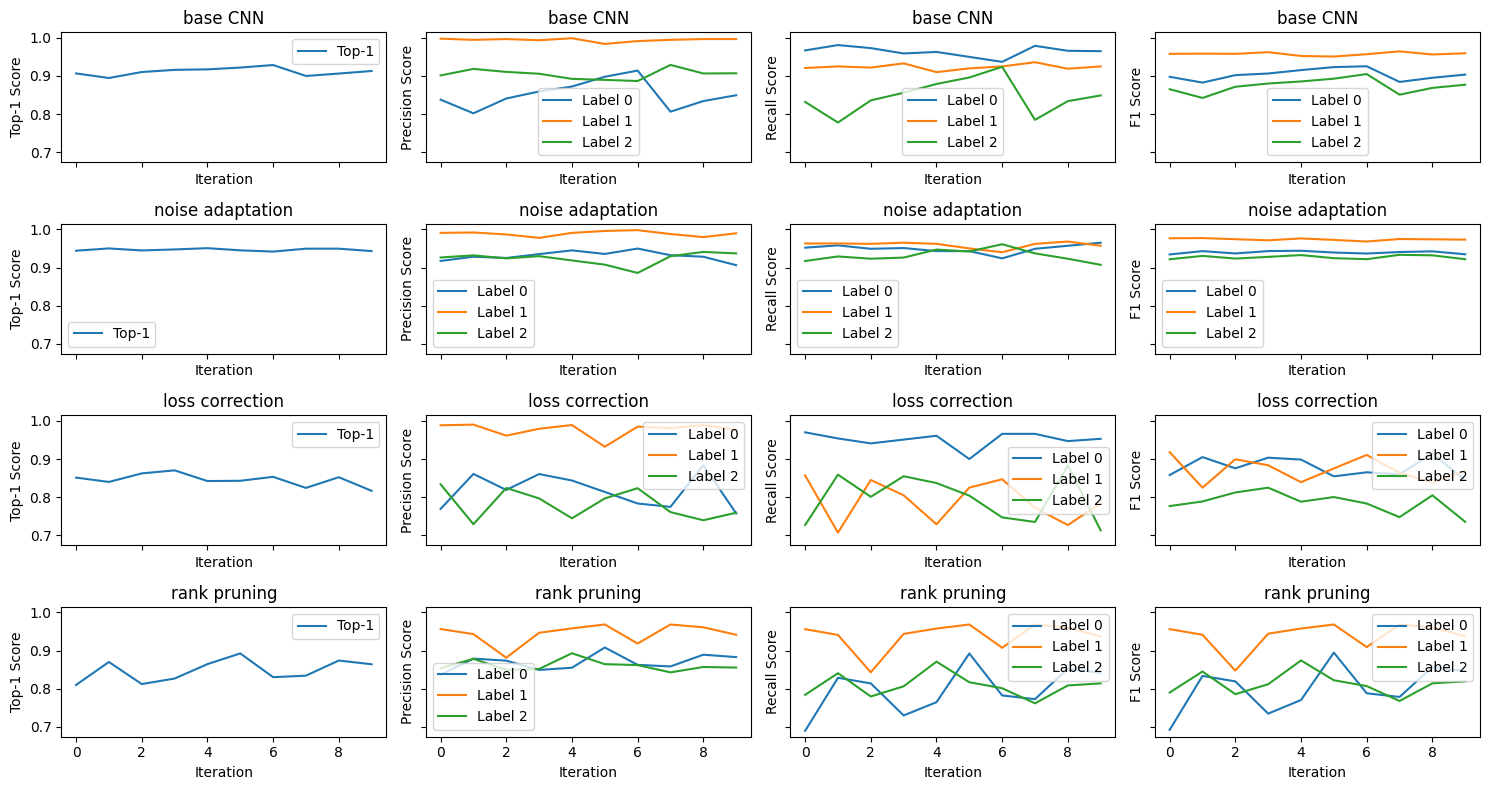

base CNN metrics:
base CNN - Top1 mean = 0.9115
base CNN - Top1 st.deviation = 0.009635870484808306
base CNN - Precision mean = [0.85148112 0.99453088 0.90479207]
base CNN - Precision st.deviation = [0.03411736 0.00408906 0.01238818]
base CNN - Recall mean = [0.964  0.9236 0.8469]
base CNN - Recall st.deviation = [0.01249    0.00690217 0.04308004]
base CNN - F1 mean = [0.90363231 0.95773387 0.87399859]
base CNN - F1 st.deviation = [0.01387219 0.00385047 0.01770724]

noise adaptation metrics:
noise adaptation - Top1 mean = 0.9465
noise adaptation - Top1 st.deviation = 0.0030632227038420545
noise adaptation - Precision mean = [0.93020917 0.98883894 0.92308789]
noise adaptation - Precision st.deviation = [0.01198404 0.00599199 0.01530412]
noise adaptation - Recall mean = [0.9491 0.9592 0.9312]
noise adaptation - Recall st.deviation = [0.01053992 0.00788416 0.01497197]
noise adaptation - F1 mean = [0.93943531 0.97374951 0.92689924]
noise adaptation - F1 st.deviation = [0.00345939 0.0026001

In [82]:
make_graph(results)

## 5.2 FashionMNIST0.6 dataset

In [83]:
filename = "FashionMNIST0.6.npz"
fashion06 = data(path,filename)
fashion06.split_train_data()
preprocess(fashion06)
print(fashion06)
param_grid = {
  "input_shape" : [28,28,1],
  "class_number" : len(fashion06.label_list),
  "activation_function" : "tanh",
  "num_filters" : 32,
  "num_layers" : 3
}

batch_size = 128

classifiers = ["base CNN", "noise adaptation", "loss correction", "rank pruning"]
results = run_experiments(classifiers, fashion06, param_grid, batch_size, num_iters = 10)

Data of FashionMNIST0.6
------------------------
training sample: (14400, 28, 28)
training label: (14400,)
validation sample: (3600, 28, 28)
validation label: (3600,)
testing sample:(3000, 28, 28)
testing label: (3000,)
Unique labels: [0 1 2]
Transition matrix:
[[0.4 0.3 0.3]
 [0.3 0.4 0.3]
 [0.3 0.3 0.4]]

Running Experiments ======================================>

Iteration Number 1
Current model: base CNN
Epoch 1/500
113/113 [==============================] - 12s 100ms/step - loss: 1.1032 - accuracy: 0.3598 - val_loss: 1.0945 - val_accuracy: 0.3736
Epoch 2/500
113/113 [==============================] - 10s 85ms/step - loss: 1.0953 - accuracy: 0.3776 - val_loss: 1.0945 - val_accuracy: 0.3697
Epoch 3/500
113/113 [==============================] - 10s 92ms/step - loss: 1.0929 - accuracy: 0.3821 - val_loss: 1.0918 - val_accuracy: 0.3894
Epoch 4/500
113/113 [==============================] - 11s 98ms/step - loss: 1.0917 - accuracy: 0.3847 - val_loss: 1.0917 - val_accuracy: 0.3917
Epoch 

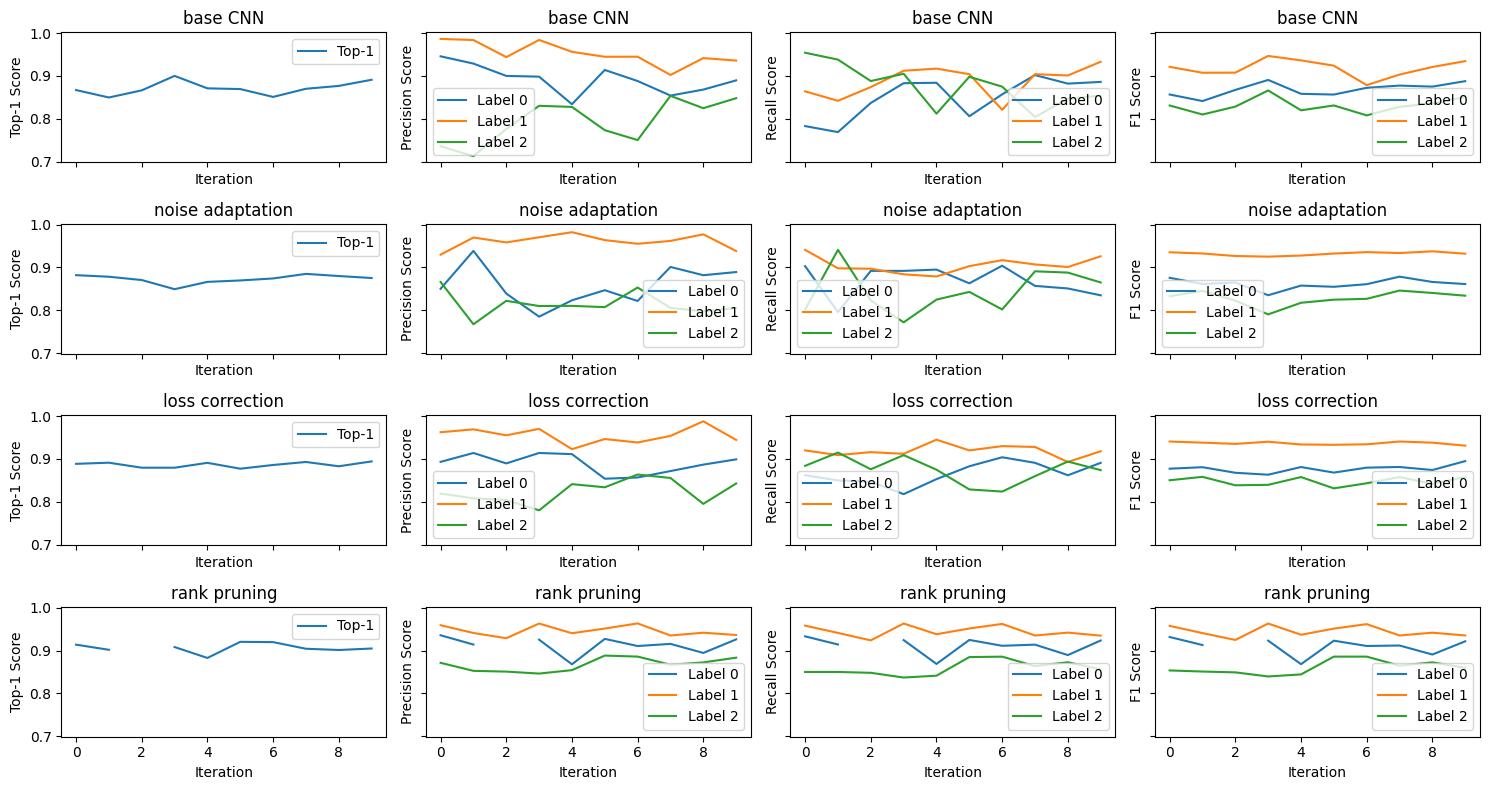

base CNN metrics:
base CNN - Top1 mean = 0.8712
base CNN - Top1 st.deviation = 0.014728807751402628
base CNN - Precision mean = [0.89203792 0.95226834 0.79333018]
base CNN - Precision st.deviation = [0.03193805 0.02496797 0.04737387]
base CNN - Recall mean = [0.8489 0.8872 0.8775]
base CNN - Recall st.deviation = [0.04523373 0.03390221 0.04688337]
base CNN - F1 mean = [0.86832181 0.91794612 0.83089918]
base CNN - F1 st.deviation = [0.01456224 0.01862292 0.01662421]

noise adaptation metrics:
noise adaptation - Top1 mean = 0.8731
noise adaptation - Top1 st.deviation = 0.009647164235037026
noise adaptation - Precision mean = [0.85776673 0.96065891 0.81458038]
noise adaptation - Precision st.deviation = [0.04273415 0.01553116 0.02635928]
noise adaptation - Recall mean = [0.8688 0.9053 0.8452]
noise adaptation - Recall st.deviation = [0.03332206 0.01770339 0.04847226]
noise adaptation - F1 mean = [0.86167584 0.93187329 0.82815446]
noise adaptation - F1 st.deviation = [0.01130395 0.00390832

In [90]:
make_graph(results)

## 5.3 CIFAR dataset

In [22]:
filename = "CIFAR.npz"
cifar = data(path,filename)
cifar.split_train_data()
preprocess(cifar)
print(cifar)
param_grid = {
  "input_shape" : [32,32,3],
  "class_number" : len(cifar.label_list),
  "activation_function" : "tanh",
  "num_filters" : 64,
  "num_layers" : 2
}

batch_size = 128

print("\nCalculating transition matrix...")
cifar.model = cnn_alg(**param_grid)
cifar.model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

cifar.model.fit(cifar.X_train,
                cifar.y_train,
                batch_size = batch_size,
                validation_data = (cifar.X_valid, cifar.y_valid),
                epochs = 500,
                callbacks = [early_stopping],
                verbose = 0)

cifar.transition_matrix = estimate_matrix(cifar, cifar.model.predict(cifar.X_test))
print(f"CIFAR's transition matrix:\n{cifar.transition_matrix}\n")

classifiers = ["base CNN", "noise adaptation", "loss correction", "rank pruning"]
results = run_experiments(classifiers, cifar, param_grid, batch_size, num_iters = 10)

Data of CIFAR
------------------------
training sample: (12000, 32, 32, 3)
training label: (12000,)
validation sample: (3000, 32, 32, 3)
validation label: (3000,)
testing sample:(3000, 32, 32, 3)
testing label: (3000,)
Unique labels: [0 1 2]
Transition matrix:
None

Calculating transition matrix...
94/94 [==============================] - 1s 8ms/step
CIFAR's transition matrix:
[[0.39697805 0.30763522 0.29538712]
 [0.31037918 0.36787933 0.32174149]
 [0.30717826 0.3137686  0.37905329]]


Running Experiments ======================================>

Iteration Number 1
Current model: base CNN
Epoch 1/500
94/94 [==============================] - 14s 138ms/step - loss: 1.1063 - accuracy: 0.3446 - val_loss: 1.0962 - val_accuracy: 0.3677
Epoch 2/500
94/94 [==============================] - 13s 133ms/step - loss: 1.0956 - accuracy: 0.3635 - val_loss: 1.0974 - val_accuracy: 0.3603
Epoch 3/500
94/94 [==============================] - 12s 129ms/step - loss: 1.0916 - accuracy: 0.3834 - val_loss: 1.0

c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


94/94 [==============================] - 12s 124ms/step - loss: 1.0980 - accuracy: 0.3467 - val_loss: 1.0977 - val_accuracy: 0.3393
Epoch 2/500
94/94 [==============================] - 12s 123ms/step - loss: 1.0959 - accuracy: 0.3652 - val_loss: 1.0953 - val_accuracy: 0.3730
Epoch 3/500
94/94 [==============================] - 13s 135ms/step - loss: 1.0944 - accuracy: 0.3712 - val_loss: 1.0951 - val_accuracy: 0.3687
Epoch 4/500
94/94 [==============================] - 14s 148ms/step - loss: 1.0939 - accuracy: 0.3748 - val_loss: 1.0952 - val_accuracy: 0.3667
Epoch 5/500
94/94 [==============================] - 13s 143ms/step - loss: 1.0947 - accuracy: 0.3704 - val_loss: 1.0944 - val_accuracy: 0.3720
Epoch 6/500
94/94 [==============================] - 11s 122ms/step - loss: 1.0931 - accuracy: 0.3806 - val_loss: 1.0946 - val_accuracy: 0.3677
Epoch 7/500
94/94 [==============================] - 12s 123ms/step - loss: 1.0920 - accuracy: 0.3850 - val_loss: 1.0969 - val_accuracy: 0.3620
Epoc

c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/500
94/94 [==============================] - 14s 138ms/step - loss: 1.0985 - accuracy: 0.3487 - val_loss: 1.1006 - val_accuracy: 0.3333
Epoch 2/500
94/94 [==============================] - 12s 133ms/step - loss: 1.0972 - accuracy: 0.3559 - val_loss: 1.0959 - val_accuracy: 0.3647
Epoch 3/500
94/94 [==============================] - 13s 135ms/step - loss: 1.0950 - accuracy: 0.3707 - val_loss: 1.0955 - val_accuracy: 0.3657
Epoch 4/500
94/94 [==============================] - 13s 134ms/step - loss: 1.0937 - accuracy: 0.3787 - val_loss: 1.0957 - val_accuracy: 0.3640
Epoch 5/500
94/94 [==============================] - 13s 138ms/step - loss: 1.0943 - accuracy: 0.3748 - val_loss: 1.0946 - val_accuracy: 0.3667
Epoch 6/500
94/94 [==============================] - 14s 152ms/step - loss: 1.0936 - accuracy: 0.3776 - val_loss: 1.0976 - val_accuracy: 0.3490
Epoch 7/500
94/94 [==============================] - 14s 144ms/step - loss: 1.0923 - accuracy: 0.3855 - val_loss: 1.0949 - val_accuracy:

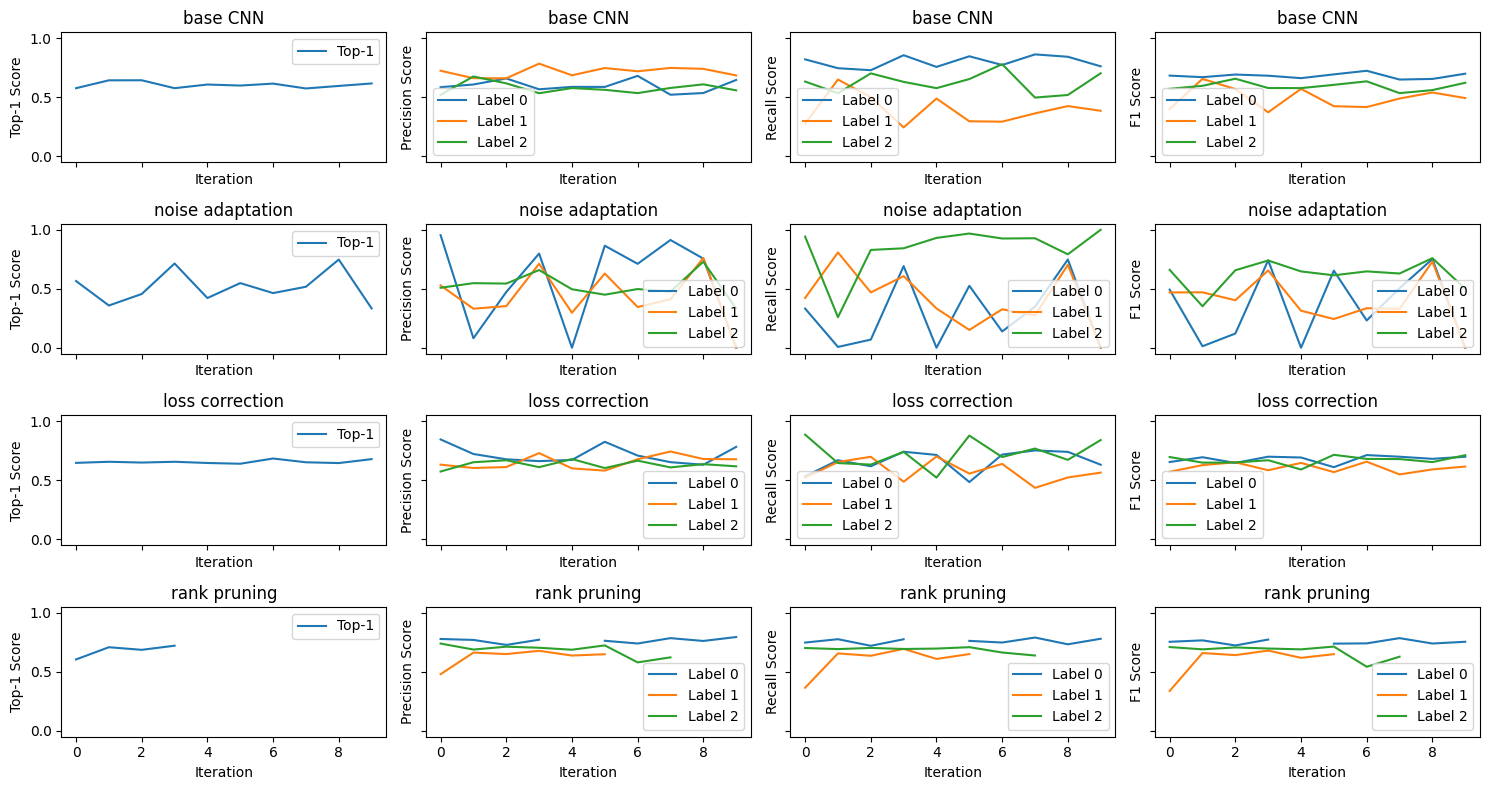

base CNN metrics:
base CNN - Top1 mean = 0.6049
base CNN - Top1 st.deviation = 0.024256064533775195
base CNN - Precision mean = [0.59787494 0.71578545 0.57693152]
base CNN - Precision st.deviation = [0.04919478 0.03920858 0.04451715]
base CNN - Recall mean = [0.7997 0.3921 0.6229]
base CNN - Recall st.deviation = [0.0485614  0.11999704 0.08667693]
base CNN - F1 mean = [0.68117166 0.49300276 0.5937442 ]
base CNN - F1 st.deviation = [0.02152591 0.08626853 0.03499672]

noise adaptation metrics:
noise adaptation - Top1 mean = 0.5123666666666666
noise adaptation - Top1 st.deviation = 0.13034837509109534
noise adaptation - Precision mean = [0.5550431  0.43663609 0.52399304]
noise adaptation - Precision st.deviation = [0.3681739  0.21531333 0.10351488]
noise adaptation - Recall mean = [0.2859 0.4094 0.8418]
noise adaptation - Recall st.deviation = [0.27418733 0.23517534 0.20390478]
noise adaptation - F1 mean = [0.35074647 0.39495755 0.62052104]
noise adaptation - F1 st.deviation = [0.29598741

In [23]:
make_graph(results)

# Appendix

Trying the noise adaptation method with only ReLU activation function for FashionMNIST0.6 and CIFAR dataset

In [18]:
filename = "FashionMNIST0.6.npz"
fashion06 = data(path,filename)
fashion06.split_train_data()
preprocess(fashion06)
print(fashion06)
param_grid = {
  "input_shape" : [28,28,1],
  "class_number" : len(fashion06.label_list),
  "activation_function" : "relu",
  "num_filters" : 32,
  "num_layers" : 3
}

batch_size = 128

classifiers = ["noise adaptation"]
results = run_experiments(classifiers, fashion06, param_grid, batch_size, num_iters = 10)

Data of FashionMNIST0.6
------------------------
training sample: (14400, 28, 28)
training label: (14400,)
validation sample: (3600, 28, 28)
validation label: (3600,)
testing sample:(3000, 28, 28)
testing label: (3000,)
Unique labels: [0 1 2]
Transition matrix:
[[0.4 0.3 0.3]
 [0.3 0.4 0.3]
 [0.3 0.3 0.4]]

Running Experiments ======================================>

Iteration Number 1
Current model: noise adaptation
Epoch 1/500
113/113 [==============================] - 8s 56ms/step - loss: 1.0984 - accuracy: 0.3397 - val_loss: 1.0975 - val_accuracy: 0.3661
Epoch 2/500
113/113 [==============================] - 6s 51ms/step - loss: 1.0968 - accuracy: 0.3656 - val_loss: 1.0950 - val_accuracy: 0.3661
Epoch 3/500
113/113 [==============================] - 7s 60ms/step - loss: 1.0945 - accuracy: 0.3735 - val_loss: 1.0923 - val_accuracy: 0.3853
Epoch 4/500
113/113 [==============================] - 7s 66ms/step - loss: 1.0924 - accuracy: 0.3860 - val_loss: 1.0915 - val_accuracy: 0.3883
Epo

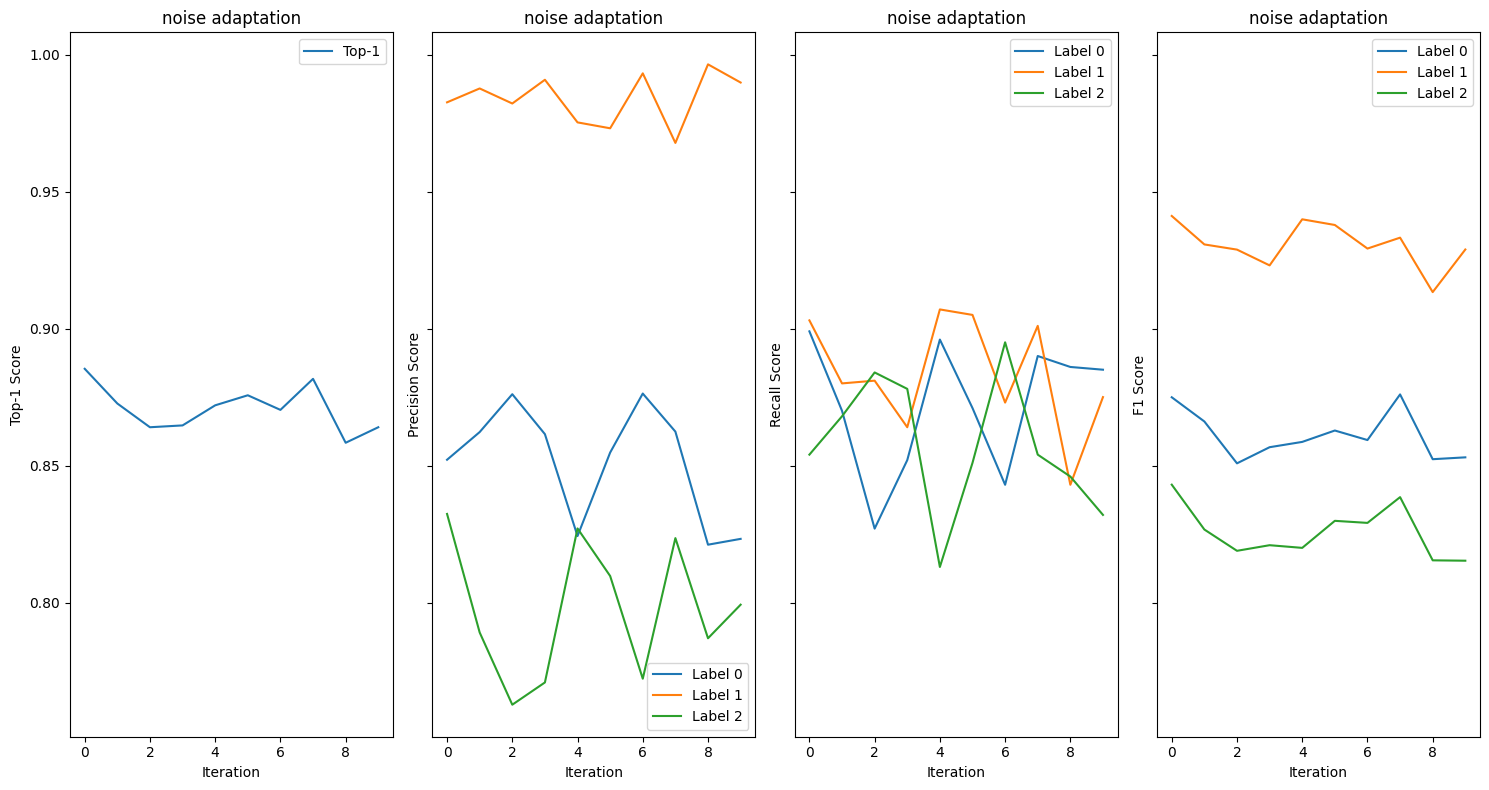

noise adaptation metrics:
noise adaptation - Top1 mean = 0.8708666666666668
noise adaptation - Top1 st.deviation = 0.008022468448052643
noise adaptation - Precision mean = [0.85140437 0.98388432 0.79737479]
noise adaptation - Precision st.deviation = [0.02005848 0.00892268 0.02378708]
noise adaptation - Recall mean = [0.8719 0.8832 0.8575]
noise adaptation - Recall st.deviation = [0.02294537 0.01980303 0.02338482]
noise adaptation - F1 mean = [0.86106852 0.93060855 0.82576418]
noise adaptation - F1 st.deviation = [0.00846924 0.00786709 0.0089974 ]



In [64]:
make_graph(results)

In [68]:
filename = "CIFAR.npz"
cifar = data(path,filename)
cifar.split_train_data()
preprocess(cifar)
print(cifar)
param_grid = {
  "input_shape" : [32,32,3],
  "class_number" : len(cifar.label_list),
  "activation_function" : "relu",
  "num_filters" : 64,
  "num_layers" : 2
}

batch_size = 128

print("\nCalculating transition matrix...")
cifar.model = cnn_alg(**param_grid)
cifar.model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

cifar.model.fit(cifar.X_train,
                cifar.y_train,
                batch_size = batch_size,
                validation_data = (cifar.X_valid, cifar.y_valid),
                epochs = 500,
                callbacks = [early_stopping],
                verbose = 0)

cifar.transition_matrix = estimate_matrix(cifar, cifar.model.predict(cifar.X_test))
print(f"CIFAR's transition matrix:\n{cifar.transition_matrix}\n")

classifiers = ["noise adaptation"]
results = run_experiments(classifiers, cifar, param_grid, batch_size, num_iters = 10)

Data of CIFAR
------------------------
training sample: (12000, 32, 32, 3)
training label: (12000,)
validation sample: (3000, 32, 32, 3)
validation label: (3000,)
testing sample:(3000, 32, 32, 3)
testing label: (3000,)
Unique labels: [0 1 2]
Transition matrix:
None

Calculating transition matrix...
94/94 [==============================] - 1s 11ms/step
CIFAR's transition matrix:
[[0.37544936 0.3067764  0.31777447]
 [0.30318174 0.37885845 0.31795949]
 [0.31620067 0.29702294 0.38677686]]


Running Experiments ======================================>

Iteration Number 1
Current model: noise adaptation
Epoch 1/500
94/94 [==============================] - 17s 163ms/step - loss: 1.0987 - accuracy: 0.3378 - val_loss: 1.0990 - val_accuracy: 0.3333
Epoch 2/500
94/94 [==============================] - 13s 141ms/step - loss: 1.0979 - accuracy: 0.3458 - val_loss: 1.0978 - val_accuracy: 0.3467
Epoch 3/500
94/94 [==============================] - 14s 147ms/step - loss: 1.0970 - accuracy: 0.3560 - val_

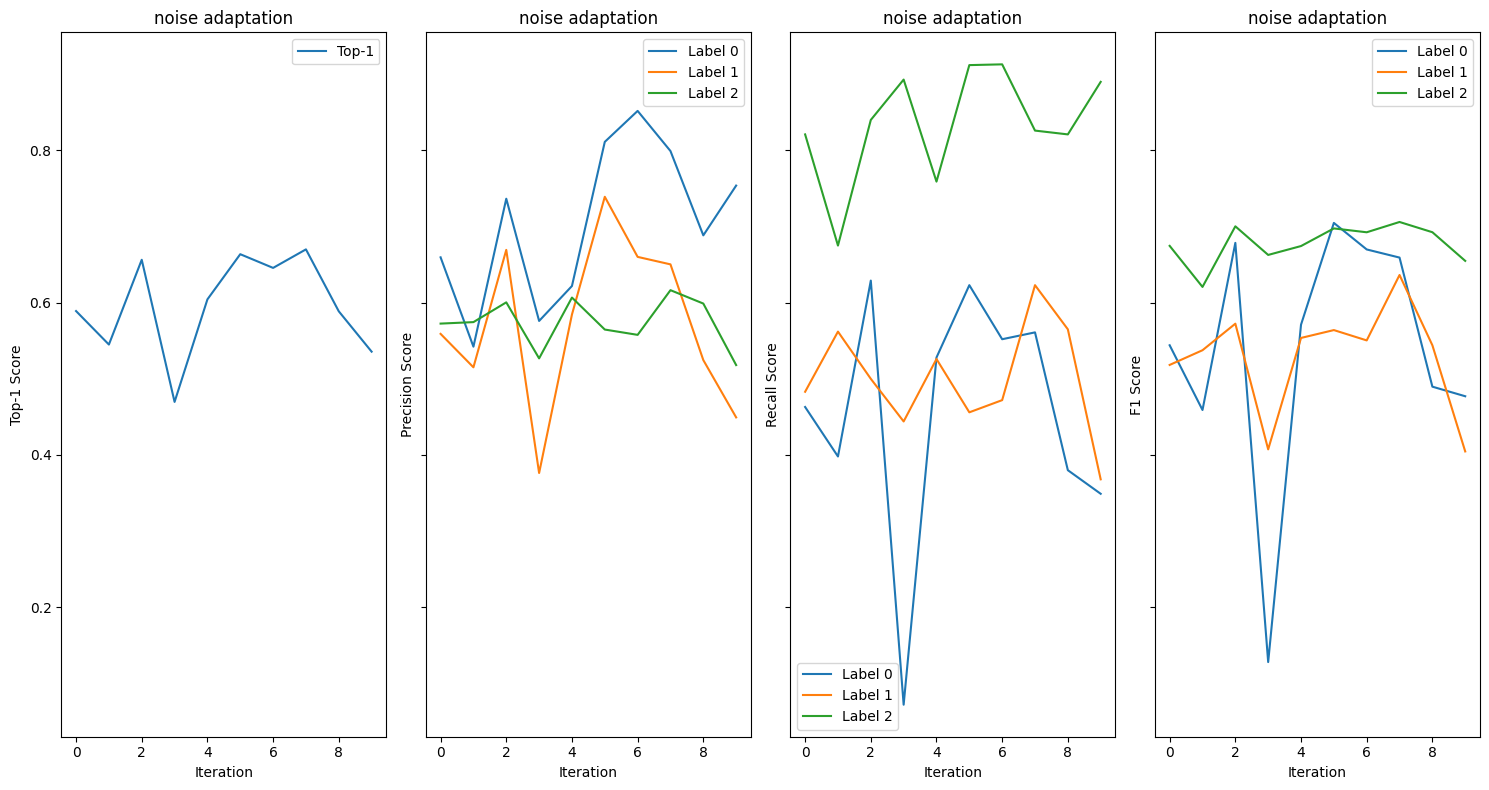

noise adaptation metrics:
noise adaptation - Top1 mean = 0.5968
noise adaptation - Top1 st.deviation = 0.062071499990826
noise adaptation - Precision mean = [0.70406011 0.5727658  0.57367082]
noise adaptation - Precision st.deviation = [0.09871745 0.10509186 0.03145146]
noise adaptation - Recall mean = [0.4555 0.4999 0.835 ]
noise adaptation - Recall st.deviation = [0.15853533 0.06887881 0.07090557]
noise adaptation - F1 mean = [0.53814435 0.52886959 0.67760457]
noise adaptation - F1 st.deviation = [0.16160368 0.0681125  0.02481187]



In [71]:
make_graph(results)

Printing unique label from testing samples

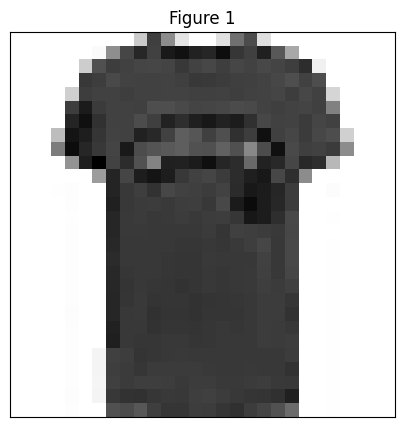

[0]


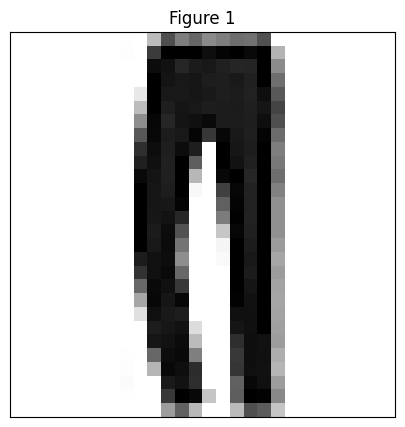

[1]


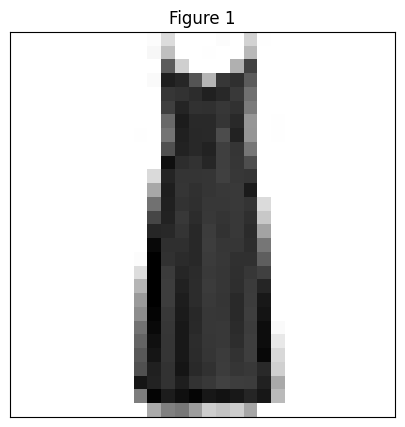

[2]


In [94]:
filename = "FashionMNIST0.5.npz"
fashion05 = data(path,filename)

unique_labels = fashion05.label_list

for label in unique_labels:
  indices_for_label = np.where(fashion05.y_test == label)[0]
  selected_indices = indices_for_label[:1]
  plot_images(fashion05.X_test[selected_indices], row=1, col=1)
  print(fashion05.y_test[selected_indices])

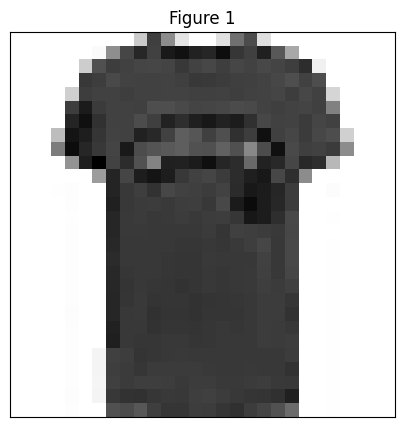

[0]


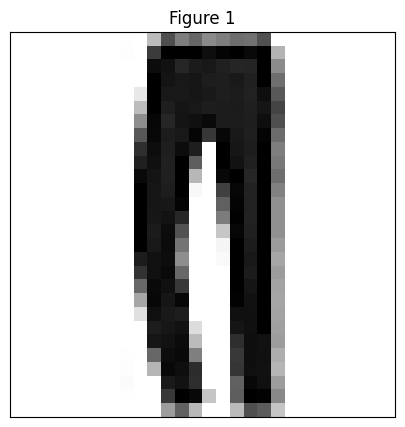

[1]


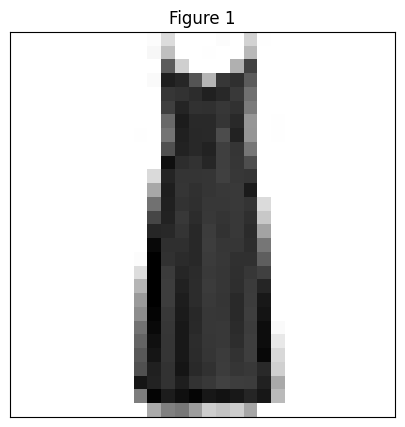

[2]


In [95]:
filename = "FashionMNIST0.6.npz"
fashion06 = data(path,filename)

unique_labels = fashion06.label_list

for label in unique_labels:
  indices_for_label = np.where(fashion06.y_test == label)[0]
  selected_indices = indices_for_label[:1]
  plot_images(fashion06.X_test[selected_indices], row=1, col=1)
  print(fashion06.y_test[selected_indices])

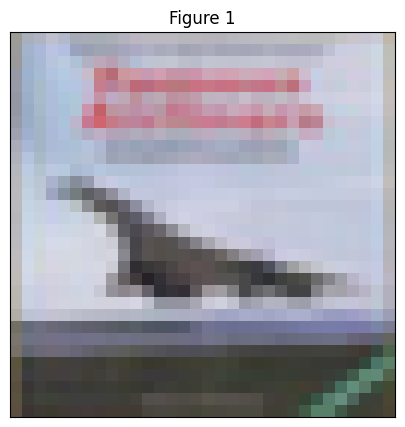

[0]


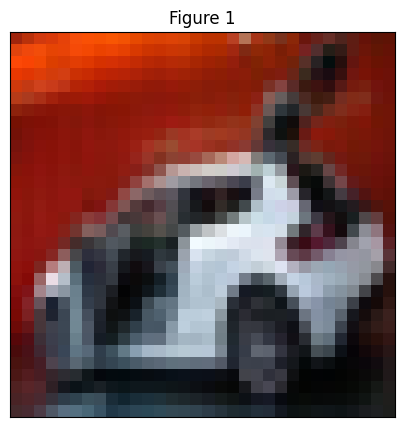

[1]


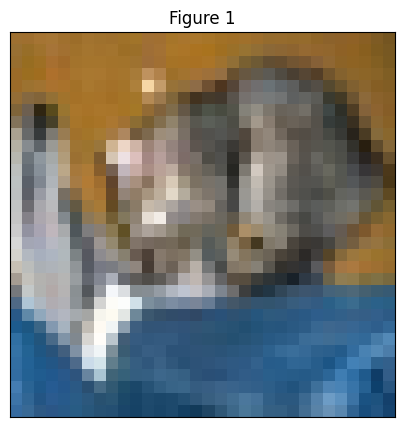

[2]


In [93]:
filename = "CIFAR.npz"
cifar = data(path,filename)

unique_labels = cifar.label_list

for label in unique_labels:
  indices_for_label = np.where(cifar.y_test == label)[0]
  selected_indices = indices_for_label[:1]
  plot_images(cifar.X_test[selected_indices], row=1, col=1)
  print(cifar.y_test[selected_indices])